# Get The data

Data Downloaded from: https://huggingface.co/datasets/saillab/taco-datasets/tree/main/multilingual-instruction-tuning-dataset%20/multilingual-alpaca-52k-gpt-4

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Amharic.json to Amharic.json
User uploaded file "Amharic.json" with length 137273925 bytes


In [9]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving tokenizer.pkl to tokenizer.pkl
User uploaded file "tokenizer.pkl" with length 268822 bytes


In [3]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8.7 MB/s eta 0:00:00


In [4]:
import os
import csv
import torch
import sacrebleu
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from torch import nn
import matplotlib.pyplot as plt
import json
import pickle
from collections import defaultdict

from transformers import AutoTokenizer
from tokenizers.pre_tokenizers import Whitespace

In [5]:
# Load the JSON data from a file
with open('Amharic.json', 'r') as file:
    data = json.load(file)

dataset = data[:1000]
# Extract English and Amharic sentences
sentence_pairs = [{'en':example['input'], 'am':example['output']} for example in dataset]

In [6]:
class BPETokenizer:
    def __init__(self, vocab_size=4000):
        self.vocab_size = vocab_size
        self.vocab = ["<|endoftext|>"]
        self.word_freqs = defaultdict(int)
        self.merges = {}
        self.tokenizer = AutoTokenizer.from_pretrained("gpt2")

    def compute_pair_freqs(self,splits):
        pair_freqs = defaultdict(int)
        for word, freq in self.word_freqs.items():
            split = splits[word]
            if len(split) == 1:
                continue
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                pair_freqs[pair] += freq
        return pair_freqs

    def merge_pair(self,a, b, splits):
        for word in self.word_freqs:
            split = splits[word]
            if len(split) == 1:
                continue

            i = 0
            while i < len(split) - 1:
                if split[i] == a and split[i + 1] == b:
                    split = split[:i] + [a + b] + split[i + 2 :]
                else:
                    i += 1
            splits[word] = split
        return splits

    def build_vocab(self, corpus):
        for text in corpus:
            self.tokenizer.backend_tokenizer.pre_tokenizer = Whitespace()
            text= ' Ġ'.join(text.split())
            words_with_offsets = self.tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
            new_words = [word for word, offset in words_with_offsets]
            for word in new_words:
                self.word_freqs[word] += 1

        alphabet = []

        for word in self.word_freqs.keys():
            for letter in word:
                if letter not in alphabet:
                    alphabet.append(letter)
        alphabet.sort()


        # Add every unique character to the vocab
        for char in alphabet:
            if char not in self.vocab:
                self.vocab.append(char)

        splits = {word: [c for c in word] for word in self.word_freqs.keys()}

        while len(self.vocab) < self.vocab_size:
            pair_freqs = self.compute_pair_freqs(splits)
            best_pair = ""
            max_freq = None
            for pair, freq in pair_freqs.items():
                if max_freq is None or max_freq < freq:
                    best_pair = pair
                    max_freq = freq
            if len(best_pair) == 2:
                splits = self.merge_pair(best_pair[0],best_pair[1], splits)
                self.merges[best_pair] = best_pair[0] + best_pair[1]
                self.vocab.append(best_pair[0] + best_pair[1])
            else:
                break


    def tokenize(self,text):
        self.tokenizer.backend_tokenizer.pre_tokenizer = Whitespace()
        pre_tokenize_result = self.tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
        pre_tokenized_text = [word for word, offset in pre_tokenize_result]
        splits = [[l for l in word] for word in pre_tokenized_text]


        for word in pre_tokenized_text:
            for char in word:
                if char not in self.vocab:
                    self.vocab.append(char)

        for pair, merge in self.merges.items():
            for idx, split in enumerate(splits):
                i = 0
                while i < len(split) - 1:
                    if split[i] == pair[0] and split[i + 1] == pair[1]:
                        split = split[:i] + [merge] + split[i + 2 :]
                    else:
                        i += 1
                splits[idx] = split

        return sum(splits, [])

    def save(self, file_path):
        """
        Save the tokenizer's state to a file.
        """
        state = {
            'vocab_size': self.vocab_size,
            'vocab': self.vocab,
            'word_freqs': dict(self.word_freqs),
            'merges': self.merges
        }
        with open(file_path, 'wb') as f:
            pickle.dump(state, f)

    @classmethod
    def load(cls, file_path):
        """
        Load a tokenizer's state from a file.
        """
        with open(file_path, 'rb') as f:
            state = pickle.load(f)

        tokenizer = cls(vocab_size=state['vocab_size'])
        tokenizer.vocab = state['vocab']
        tokenizer.word_freqs = defaultdict(int, state['word_freqs'])
        tokenizer.merges = state['merges']
        return tokenizer

In [10]:
tokenizer_file = "tokenizer.pkl"

def encode(text):
    # Step 1: Encode, decode, and normalize the text
    text = text.encode('utf-8').decode('utf-8').lower()
    text = 'Ġ'.join(text.split())

    # Step 2: Load tokenizer
    tokenizer_instance = BPETokenizer.load(tokenizer_file)

    # Step 3: Create a dictionary for vocabulary for O(1) lookups
    vocab_dict = {token: idx for idx, token in enumerate(tokenizer_instance.vocab)}

    # Step 4: Tokenize the text
    tokens = tokenizer_instance.tokenize(text)

    # Step 5: Generate token IDs efficiently
    unknown_token_id = len(tokenizer_instance.vocab)
    token_ids = [vocab_dict.get(t, unknown_token_id) for t in tokens]

    return token_ids

def decode(token_ids):
    tokenizer_instance = BPETokenizer.load(tokenizer_file)
    tokens = []
    for id in token_ids:
        if 0 <= id < len(tokenizer_instance.vocab):
            tokens.append(tokenizer_instance.vocab[id])
        else:
            # Handle out-of-vocabulary token IDs
            tokens.append('<UNK>')
    decoded_string = ''.join(tokens)
    decoded_string = decoded_string.replace('Ġ', ' ').strip()
    return decoded_string

In [11]:
def tokenize_pair(pair, tokenizer):
    """
    Tokenize a pair of English and Amharic sentences using custom tokenizers.

    Args:
        pair (dict): A dictionary with 'en' and 'am' keys for English and Amharic sentences.
        tokenizer (function): Custom English + Amharic tokenizer function.

    Returns:
        dict: Tokenized inputs for both languages.
    """
    en_tokens = tokenizer(pair['en'])
    am_tokens = tokenizer(pair['am'])

    return {
        'en_input_ids': torch.tensor(en_tokens, dtype=torch.long),
        'am_input_ids': torch.tensor(am_tokens, dtype=torch.long),
    }

# Preprocess data
tokenized_data = [tokenize_pair(pair, encode) for pair in sentence_pairs]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [12]:
def pad_sequence(seq, max_length, pad_token=0):
    if len(seq) < max_length:
        padding = torch.full((max_length - len(seq),), pad_token, dtype=seq.dtype)
        return torch.cat((seq, padding))
    else:
        return seq[:max_length]


max_length = 64  # Example max length
tokenized_data2 = [
    {
        'en_input_ids': torch.tensor(pad_sequence(pair['en_input_ids'], max_length)),
        'am_input_ids': torch.tensor(pad_sequence(pair['am_input_ids'], max_length)),
    }
    for pair in tokenized_data
]


<ipython-input-12-53a7ffe64c70>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'en_input_ids': torch.tensor(pad_sequence(pair['en_input_ids'], max_length)),
<ipython-input-12-53a7ffe64c70>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'am_input_ids': torch.tensor(pad_sequence(pair['am_input_ids'], max_length)),


In [16]:
class SimpleSeq2Seq(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(SimpleSeq2Seq, self).__init__()

        # Encoder
        self.encoder_embedding = nn.Embedding(input_dim, embedding_dim)
        self.encoder_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Decoder
        self.decoder_embedding = nn.Embedding(output_dim, embedding_dim)
        self.decoder_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Output Layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, en_input, am_input):
        # Encoder
        en_embedded = self.encoder_embedding(en_input)
        _, (hidden, cell) = self.encoder_lstm(en_embedded)

        # Decoder
        am_embedded = self.decoder_embedding(am_input)
        decoder_output, _ = self.decoder_lstm(am_embedded, (hidden, cell))

        # Output Layer
        output = self.fc_out(decoder_output)
        return output


# Define dataset and dataloader
class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = TranslationDataset(tokenized_data2)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
# Initialize model, loss, and optimizer
input_dim = BPETokenizer().vocab_size #len(en_tokenizer)
output_dim = BPETokenizer().vocab_size #len(am_tokenizer)
embedding_dim = 256
hidden_dim = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleSeq2Seq(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding tokens
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
import torch
import os
import csv
import sacrebleu
import random

# Training setup
epochs = 5
early_stopping_patience = 5
best_loss = float('inf')
patience_counter = 0
save_dir = "./BPE_Q1_checkpoints"
os.makedirs(save_dir, exist_ok=True)
results_file = "training_results.csv"

# Save training metadata (only once at the beginning)
with open(results_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "BLEU", "CHRF"])

# Mixed Precision Setup (if using compatible hardware)
scaler = torch.cuda.amp.GradScaler()

# Training loop
losses, bleu_scores, chrf_scores = [], [], []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        # Randomly select direction (0 for English to Amharic, 1 for Amharic to English)
        direction = random.choice([0, 1])

        if direction == 0:  # English to Amharic
            en_input = batch['en_input_ids'].to(device)
            am_input = batch['am_input_ids'].to(device)
        else:  # Amharic to English
            en_input = batch['am_input_ids'].to(device)  # Reverse the input
            am_input = batch['en_input_ids'].to(device)  # Reverse the target

        optimizer.zero_grad()

        # Mixed Precision Forward and Backward Pass
        with torch.cuda.amp.autocast():
            output = model(en_input, am_input)
            loss = loss_fn(output.view(-1, output_dim), am_input.view(-1))

        # Backward pass with scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)

    # Validation metrics (only at the end of the epoch)
    model.eval()
    with torch.no_grad():
        references, hypotheses = [], []
        for batch in dataloader:
            # Alternate between English-to-Amharic and Amharic-to-English for validation
            direction = random.choice([0, 1])

            if direction == 0:  # English to Amharic
                en_input = batch['en_input_ids'].to(device)
                am_input = batch['am_input_ids'].to(device)
            else:  # Amharic to English
                en_input = batch['am_input_ids'].to(device)
                am_input = batch['en_input_ids'].to(device)

            output = model(en_input, am_input)
            predicted = output.argmax(dim=-1).cpu().tolist()

            references.extend(batch['am_input_ids'].tolist())
            hypotheses.extend(predicted)

        # Decode for BLEU/CHRF scoring (after full batch)
        references = [[decode(ref)] for ref in references]
        hypotheses = [decode(hyp) for hyp in hypotheses]

        bleu = sacrebleu.corpus_bleu(hypotheses, references).score
        chrf = sacrebleu.corpus_chrf(hypotheses, references).score
        bleu_scores.append(bleu)
        chrf_scores.append(chrf)

    # Log results (only at the end of the epoch)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, BLEU: {bleu:.4f}, CHRF: {chrf:.4f}")
    with open(results_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, avg_loss, bleu, chrf])

    # Save model if it improves
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch_{epoch + 1}.pt"))
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break


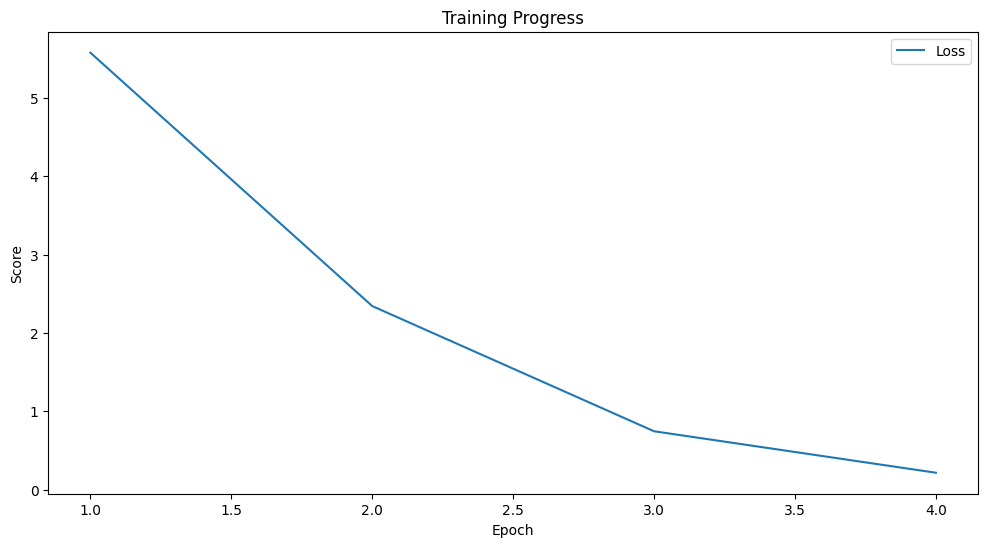

In [19]:
# Plot training results
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(losses) + 1), losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Training Progress")
plt.legend()
plt.show()

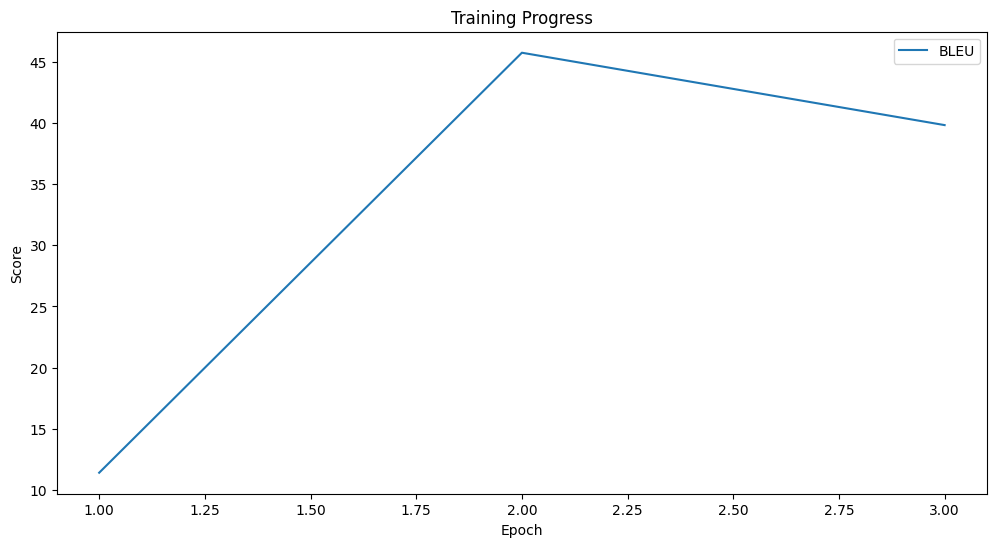

In [20]:
# Plot training results
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(bleu_scores) + 1), bleu_scores, label="BLEU")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Training Progress")
plt.legend()
plt.show()

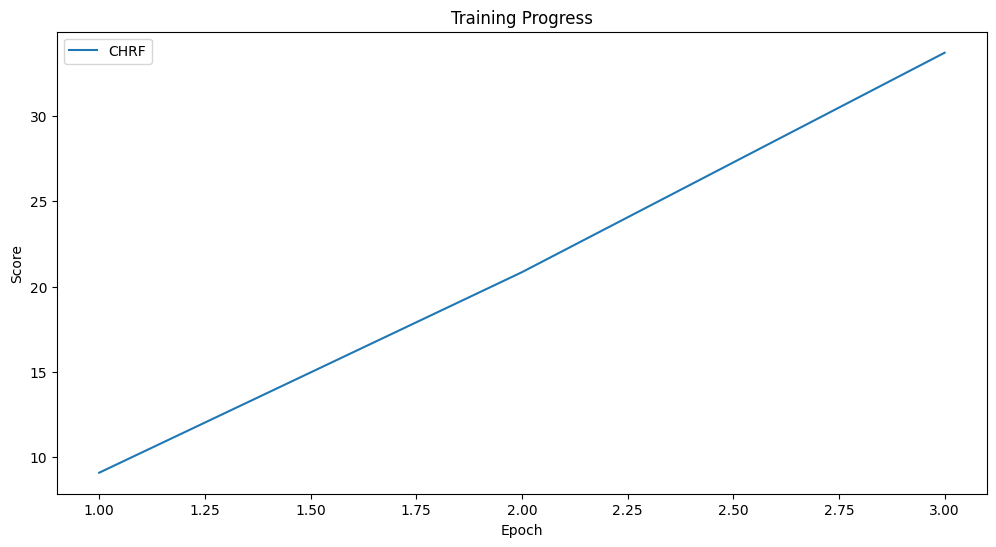

In [21]:
# Plot training results
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(chrf_scores) + 1), chrf_scores, label="CHRF")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Training Progress")
plt.legend()
plt.show()

In [23]:
import pandas as pd
training_data = {
    "Epoch": list(range(1, len(losses) + 1)),
    "Loss": losses,
    "BLEU": bleu_scores,
    "CHRF": chrf_scores
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(training_data)

# Save the DataFrame to a CSV file
csv_file = "training_results_SEQ_SEQ.csv"
df.to_csv(csv_file, index=False)
print(f"Training data saved to {csv_file}")

Training data saved to training_results_SEQ_SEQ.csv


In [24]:
def translate_sentence(model, sentence, tokenizer, max_length=64, pad_token=0, sos_token=1, eos_token=2):
    """
    Translate a sentence using the given SEQtoSEQ model and custom tokenizer.

    Args:
    - model: The trained translation model.
    - sentence: The input sentence to translate.
    - tokenizer: The custom tokenizer (e.g., BPETokenizer).
    - max_length: The maximum sequence length (default: 64).
    - pad_token: The padding token ID (default: 0).
    - sos_token: The start-of-sequence token ID (default: 1).
    - eos_token: The end-of-sequence token ID (default: 2).

    Returns:
    - translation: The translated sentence as a string.
    """
    model.eval()
    with torch.no_grad():
        # Tokenize the input sentence
        token_ids = encode(sentence)

        # Debugging: Check the tokenized output
        print(f"Token IDs: {token_ids}")

        # Pad the tokenized sequence to the max_length
        token_ids = token_ids[:max_length]  # Truncate if necessary
        padding_length = max_length - len(token_ids)
        token_ids += [pad_token] * padding_length  # Pad to the max_length

        # Debugging: Check the padded sequence
        print(f"Token IDs after padding: {token_ids}")

        # Convert token IDs to tensor and move to the correct device
        input_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

        # Initialize the target sequence with the start-of-sequence token
        target_ids = [sos_token]
        target_tensor = torch.tensor(target_ids, dtype=torch.long).unsqueeze(0).to(device)  # Shape: (1, 1)

        # Decode the sequence using greedy decoding
        for _ in range(max_length):
            # Forward pass
            output = model(input_tensor, target_tensor)  # Shape: (1, target_len, vocab_size)
            next_token_logits = output[:, -1, :]  # Get the logits of the last generated token
            next_token_id = next_token_logits.argmax(dim=-1).item()  # Choose the token with the highest probability

            # Append the predicted token to the target sequence
            target_ids.append(next_token_id)
            target_tensor = torch.tensor(target_ids, dtype=torch.long).unsqueeze(0).to(device)

            # Stop decoding if the end-of-sequence token is generated
            if next_token_id == eos_token:
                break

        # Decode the token IDs back to text
        translation = decode(target_ids[1:])  # Exclude the start-of-sequence token
        return translation

In [27]:
# Example usage
example_sentence = "What are the three primary colors?"
translation = translate_sentence(model, example_sentence, BPETokenizer.load(tokenizer_file))
print(f"English: {example_sentence}")
print(f"Amharic Translation: {translation}")

In [28]:
# Example usage
example_sentence = "ጤናማ ለመሆን ሶስት ምክሮችን ይስጡ."
translation = translate_sentence(model, example_sentence, BPETokenizer.load(tokenizer_file))
print(f"Amharic: {example_sentence}")
print(f"English Translation: {translation}")